# Introduction

![](https://visionplatform.ai/wp-content/uploads/2024/02/vision-transformer.webp)

In this tutorial, we will explore how to build a Vision Transformer (ViT) model from scratch using PyTorch. The Vision Transformer, introduced by Google Research in their original paper (https://arxiv.org/pdf/2010.11929v2), has revolutionized the way we approach image classification tasks by applying the principles of Transformers—originally designed for natural language processing—directly to image data. Instead of relying on convolutional neural networks (CNNs), ViTs split images into patches and treat them as sequences, much like words in a sentence.

We will cover everything from preparing the data and building the model architecture to training and evaluating the model. By the end of this tutorial, you'll have a solid understanding of the underlying principles behind Vision Transformers and how to implement them using PyTorch.

This tutorial is based and fully inspired from this article: https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6

# Build The Model

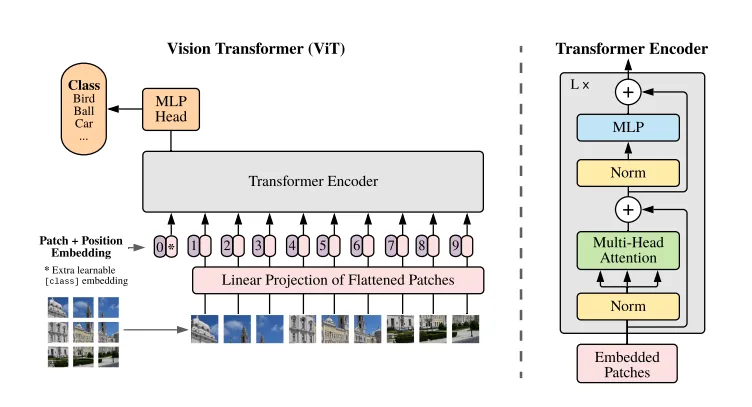

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

for tutorial purposes, I will use one batch of RGB images with a size of 32x32 as many as 10 images.

In [2]:
# test sample
imgs = torch.randn(10, 3, 32, 32)
imgs.shape

torch.Size([10, 3, 32, 32])

## Patch Embedding

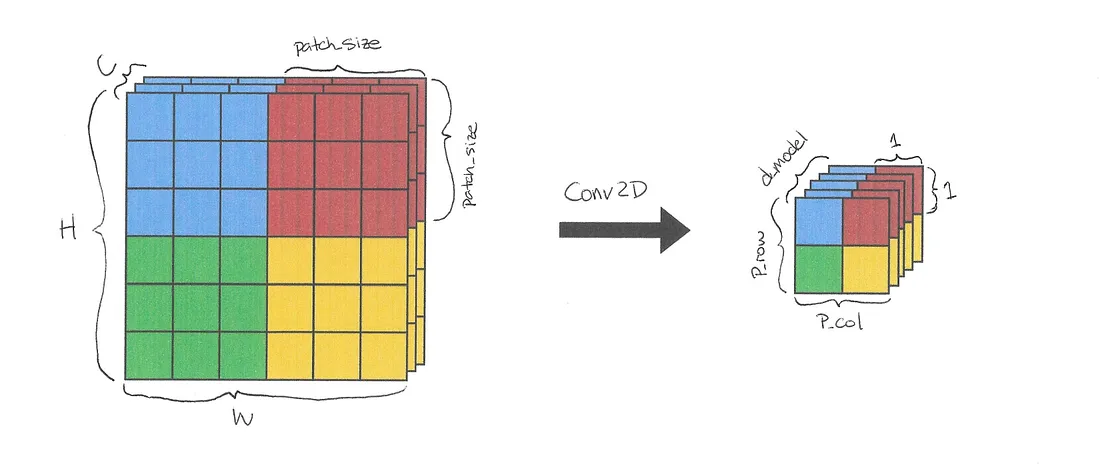

Here’s a paragraph incorporating your description:

In the initial stage, the input image needs to go through an embedding process. To achieve this, we first need to divide the image into smaller patches. In this tutorial, I accomplish this by converting the image into 2x2 patches using a 2D convolutional layer. This step is crucial because Vision Transformers process images as sequences of patches, similar to how text is handled in traditional Transformers. By using a convolutional layer, we efficiently extract these patches, which can then be flattened and embedded for further processing within the model.

In [3]:
# input = (B, C, H, W)
# output = (B, d_model, P,P) where P = H/patch_size
#strategi: out_channels be d_model, stride=kernel_size=pathsize=H/2

In [4]:
#patching to (B, d_model, P, P)
d_model = 9 #for example we use 9 dimension
patch_size = 2
P = imgs.shape[-1]/patch_size

input_channel = 3 #because of input image has 3 filter
out_channel = d_model
kernel_size = stride = (P, P)

pe = linear_project = nn.Conv2d(in_channels=3, out_channels = 9, kernel_size=(14,14), stride=(14,14))
lin_img = linear_project(imgs)
lin_img.shape

torch.Size([10, 9, 2, 2])

after we flatten the image to combine the patch row and patch col 

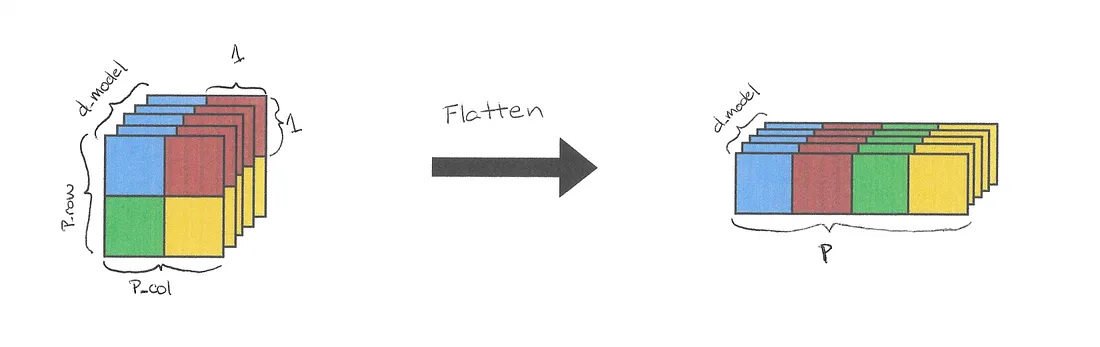

In [5]:
#flatten the matrix
#from (B, d_model, P, P)--> (B, d_model, 2P)
flat_img = lin_img.flatten(2) #(B, d_model, P, P) --> (B, d_model, 2P)
flat_img.shape

torch.Size([10, 9, 4])

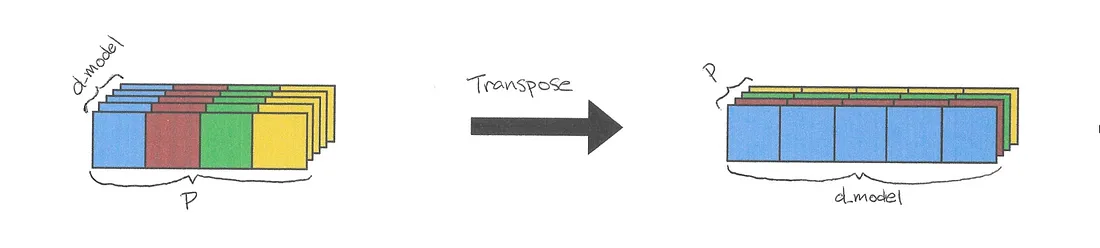

finally we can transpose to replace the position of P with d_model

In [6]:
#(B, d_model, 2P)-->(B, 2P, d_model)
trans_img = flat_img.transpose(dim0 = -1, dim1 = -2)
trans_img.shape

torch.Size([10, 4, 9])

overall steps, can be combined into a class `PatchEmbedding`

In [7]:
class PatchEmbedding(nn.Module):
    """
    (B, C, H, W) --> (B, patch_size, d_model)
    """
    def __init__(self, d_model, img_size, patch_size, out_channel):
        super().__init__()
        
        self.d_model = d_model
        self.input_size = img_size
        self.patch_size = patch_size
        self.channel = out_channel
        
        self.linear_patch = nn.Conv2d(
            in_channels=self.channel, 
            out_channels = self.d_model, 
            kernel_size = self.patch_size, 
            stride = self.patch_size
        )
        
    def forward(self, img):
        out = self.linear_patch(img) # (B, C, H, W) --> (B, d_model, P, P)
        out = out.flatten(2) #(B, d_model, P, P) --> (B, d_model, 2P)
        out = out.transpose(dim0=-1, dim1=-2) #(B, 2P, d_model)
        
        return out

## Positional Embedding

Next, each position of the patch embeddings needs to be encoded using positional embeddings. In this tutorial, the positional embeddings are added after the patch embeddings have been concatenated with a [CLS] token. The [CLS] token, often used in Transformer models, represents the overall information of the input and is essential for classification tasks. By adding positional embeddings, we ensure that the model retains the spatial information of the patches, allowing it to understand the relative positions of each patch within the image.

In [8]:
cls_token = nn.Parameter(torch.randn(1, 1, 9))
cls_token.shape

torch.Size([1, 1, 9])

In [9]:
#create cls token in bacth dimension using torch expand
token_batch = cls_token.expand(trans_img.shape[0], -1, -1)
token_batch.shape

torch.Size([10, 1, 9])

In [10]:
#adding to trans_img using concat on dim=-1
#(B, 2P, d_model) --> (B, 2P+1, d_model)
trans_img = torch.cat((token_batch, trans_img), dim = 1)
trans_img.shape

torch.Size([10, 5, 9])

Each positional encoding is unique to the position that it represents which allows model to identify which position each embedding is supposed to go. In order for the positional encodings to be added to the embeddings, they have to have the same dimension, d_model.

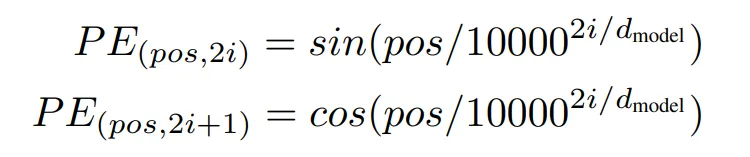

the value of 5 comes from trans_img where dim 1 has a value of 4, due to the addition of a 1-dimensional cls token, the dimension of trans_img becomes 5.

In [11]:
# value 5 from trans_img[1] + 1 (from cls token)
max_seq_length = 5
pe = torch.zeros(max_seq_length, d_model)

for row in range(max_seq_length):
    for col in range(d_model):
        if col % 2==0:
            pe[row][col] = np.sin(row/(10000)**(row/9))
        else:
            pe[row][col] = np.cos(row/(10000)**((row-1)*row/9))
pe.shape

torch.Size([5, 9])

In [12]:
#(B, 2P+1, d_model)+(2P+1, d_model)--> (B, 2P+1, d_model)
trans_img = trans_img + pe
trans_img.shape

torch.Size([10, 5, 9])

In [13]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_length, d_model):
        super().__init__()
        
        self.max_seq_length  = max_seq_length
        self.d_model = d_model
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # Classification Token (1, 1, d_model)

        
        pe = torch.zeros(self.max_seq_length, self.d_model)
        for row in range(self.max_seq_length):
            for col in range(self.d_model):
                if col % 2==0:
                    pe[row][col] = np.sin(row/(10000)**(row/9))
                else:
                    pe[row][col] = np.cos(row/(10000)**((row-1)*row/9))
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.shape[0], -1, -1)
        
        x = torch.cat((tokens_batch, x), dim = 1) #(B, P*P, d_model) + (B, 1, d_model) --> (B, P*P+1, d_model)
        x = x+self.pe
        return x #(B, P*P+1, d_model)

## Attention Head

Next, we focus on building the attention heads, a key component in the Vision Transformer. Attention heads allow the model to weigh the importance of different patches relative to one another by computing attention scores. In this tutorial, I implement a multi-head self-attention mechanism, where each attention head captures unique aspects of the image by focusing on different regions. We achieve this by projecting the input embeddings into query, key, and value vectors, which are then used to calculate the attention scores. The outputs from multiple heads are concatenated and passed through a linear layer to combine the information. This setup allows the model to learn complex patterns by attending to different parts of the image simultaneously.

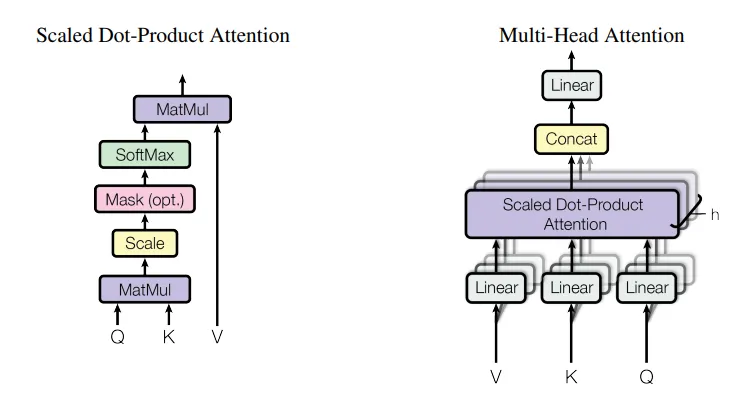

In [14]:
# create query, key, value from linear layer in d_model x head_size dimension
head_size = 7 # value 10 is for example

query = nn.Linear(d_model, head_size)
key = nn.Linear(d_model, head_size)
value = nn.Linear(d_model, head_size)

#applying image to linear layer
Q = query(trans_img) #(B, P*P+1, d_model)x(d_model, head_size) --> (B, P*P+1, head_size)
K = key(trans_img)
V = value(trans_img)

print(f'{Q.shape=}')
print(f'{K.shape=}')
print(f'{V.shape=}')

Q.shape=torch.Size([10, 5, 7])
K.shape=torch.Size([10, 5, 7])
V.shape=torch.Size([10, 5, 7])


We are able to get the relationship between the tokens in a sequence by getting the dot product of the queries and keys.

In [15]:
#create attention relationship
#(B, 2P+1, head_size) x (B, head_size, 2P+1) --> (B, 2P+1, 2P+1)
att = Q@K.transpose(dim0=-1, dim1=-2)
att = att/np.sqrt(d_model)
att = torch.softmax(att, dim=-1)
att.shape

torch.Size([10, 5, 5])

<Axes: >

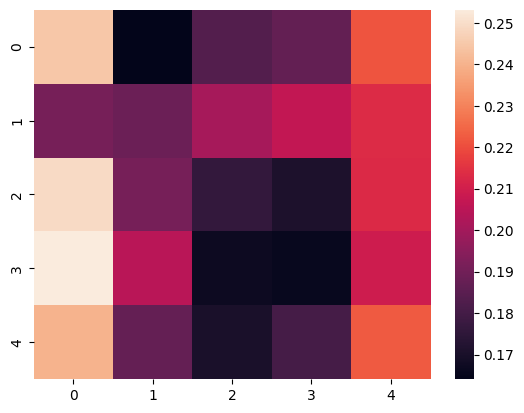

In [16]:
import seaborn as sns

#heatmap for the first example 
sns.heatmap(att[0].detach().numpy())

In [17]:
#(B, 2P+1, 2P+1) x (2P+1, head_size) --> (B, 2P+1, head_size)
att = att @ V
att.shape

torch.Size([10, 5, 7])

<Axes: >

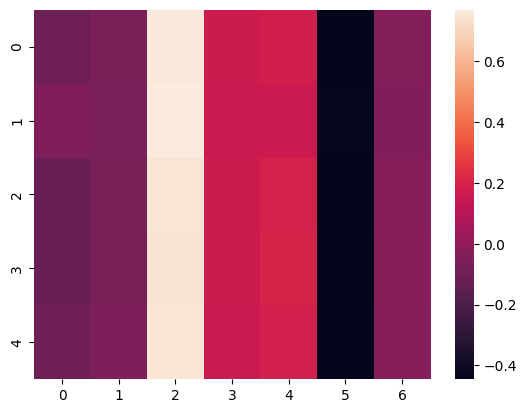

In [18]:
sns.heatmap(att[0].detach().numpy())

In [19]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        
        self.query = nn.Linear(d_model, head_size) #(d_model, head_size)
        self.key = nn.Linear(d_model, head_size) #(d_model, head_size)
        self.value = nn.Linear(d_model, head_size) #(d_model, head_size)
    
    def forward(self, x):
        # x (B, P*P+1, d_model)
        Q = self.query(x) #(B, P*P+1, head_size)
        K = self.key(x) #(B, P*P+1, head_size)
        V = self.value(x) #(B, P*P+1, head_size)
        
        QK = Q @ K.transpose(dim0=-2, dim1=-1) #(B, P*P+1, P*P+1)
        #scaling
        att = QK/np.sqrt(d_model)
        att = torch.softmax(att, dim = -1)
        
        att = att @ V #(B, 2P+1, head_size)
        return att

## Multi head

After defining a single attention head, we move on to constructing the multi-head attention mechanism. The multi-head attention layer is a critical part of the Vision Transformer, enabling the model to capture diverse patterns across different parts of the image. Instead of relying on a single attention process, we use multiple attention heads running in parallel. Each head independently learns to focus on different aspects of the image by projecting the input embeddings into distinct query, key, and value spaces. The outputs from all heads are then concatenated and passed through a linear layer. This design allows the model to gather a broader range of contextual information, which is vital for accurately interpreting complex image features.

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        
        super().__init__()
        
        self.head_size = d_model//n_heads
        self.W_o = nn.Linear(d_model, d_model)
        self.att_n = nn.ModuleList([AttentionHead(d_model, self.head_size) for i in range(n_heads)])
        
    def forward(self, x):
        x = torch.cat([att(x) for att in self.att_n], dim = -1) #(B, 2P+1, head_size*n_heads)
        x = self.W_o(x)#(B, 2P+1, head_size*n_heads)x(d_model, d_model) --> (B, 2P+1, d_model)
        return x 

In [21]:
n_heads = 3

W_o = nn.Linear(d_model, d_model)
att_n = nn.ModuleList([AttentionHead(d_model, d_model//n_heads) for i in range(n_heads)])
x = torch.cat([att_i(trans_img) for att_i in att_n], dim = -1)
x = W_o(x)
x.shape

torch.Size([10, 5, 9])

## Transformer Encoder

The transformer encoder is made up of two sub-layers: the first sub-layer performs multi-head attention and the second sub-layer contains a multi-layer perceptron. The multi-head attention sub-layer performs communication between tokens while the multi-layer perceptron sub-layers allows the tokens to individually “think” on what was communicated to them.

The MLP will consist of two linear layers with a GELU layer in between. GELU is used instead of RELU because it doesn’t have RELU’s limitation of being non-differentiable at zero.

In [22]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp = 4):
        super().__init__()
        
        # normalization 
        self.norm1 = nn.LayerNorm(d_model)
        
        self.multiheadattention = MultiHeadAttention(d_model, n_heads) #(B, 2P+1, d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        #MLP
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model*r_mlp),
            nn.GELU(),
            nn.Linear(d_model*r_mlp, d_model)
        ) #(B, 2P+1, d_model)
    
    def forward(self, x):
        
        out1 = self.norm1(x)
        out1 = self.multiheadattention(out1)
        out1 += x
        
        out2 = self.norm2(out1)
        out2 = self.mlp(out2)
        out2 +=out1
        
        return out2 #(B, 2P+1, d_model)

## Vision Transformer

Finally, we integrate all the components to form the complete Vision Transformer model. This involves combining the patch embedding, positional embedding, and multi-head attention layers into a cohesive architecture. First, the input image is split into patches and embedded using a 2D convolutional layer, followed by the addition of positional embeddings and a [CLS] token. These embeddings are then fed into the multi-head attention layers, where they undergo self-attention processes to capture intricate patterns and relationships between patches. The outputs of the attention layers are passed through feed-forward networks and layer normalization to refine the representation. By stacking multiple such layers, the Vision Transformer learns to capture complex features and dependencies across the entire image, enabling it to perform effective image classification and other vision tasks.

In [23]:
lin_class = nn.Linear(9, 10)
softmax = nn.Softmax(dim = -1)

proba = softmax(lin_class(x[:,0]))
proba

tensor([[0.1599, 0.1081, 0.0868, 0.0691, 0.0952, 0.0882, 0.1381, 0.0736, 0.0868,
         0.0943],
        [0.1534, 0.1038, 0.0914, 0.0755, 0.0913, 0.0933, 0.1364, 0.0779, 0.0872,
         0.0898],
        [0.1514, 0.1096, 0.0841, 0.0684, 0.1019, 0.0847, 0.1326, 0.0775, 0.0906,
         0.0993],
        [0.1595, 0.1032, 0.0978, 0.0772, 0.0978, 0.0825, 0.1381, 0.0779, 0.0766,
         0.0894],
        [0.1639, 0.1083, 0.0851, 0.0676, 0.1020, 0.0782, 0.1359, 0.0719, 0.0863,
         0.1008],
        [0.1576, 0.1097, 0.0853, 0.0701, 0.1021, 0.0805, 0.1319, 0.0792, 0.0895,
         0.0941],
        [0.1611, 0.1090, 0.0853, 0.0676, 0.1031, 0.0802, 0.1362, 0.0734, 0.0852,
         0.0988],
        [0.1722, 0.1040, 0.0871, 0.0695, 0.1046, 0.0754, 0.1358, 0.0729, 0.0828,
         0.0957],
        [0.1602, 0.1055, 0.0905, 0.0719, 0.0980, 0.0840, 0.1370, 0.0755, 0.0833,
         0.0941],
        [0.1522, 0.1040, 0.0978, 0.0754, 0.0977, 0.0892, 0.1408, 0.0766, 0.0745,
         0.0918]], grad_fn=<

In [24]:
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.n_patches = (img_size[0] * img_size[1]) // (patch_size[0] * patch_size[1])
        self.max_seq_length = self.n_patches + 1
        
        self.patchembedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        self.positionalembedding = PositionalEmbedding(self.max_seq_length, d_model)
        self.transformerencoder = nn.Sequential(*[TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])
        
        #classification MLP
        self.classification = nn.Sequential(
            nn.Linear(d_model, n_classes),
            nn.Softmax(dim = -1)
        ) 
        
    def forward(self, x):
        out = self.patchembedding(x)
        out = self.positionalembedding(out)
        out = self.transformerencoder(out)#(B, 2P+1, d_model)
        out = self.classification(out[:,0])#(B, n_classes)

        return out

# Train Model

In [25]:
d_model = 9
n_classes = 10
img_size = (32,32)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 128
epochs = 100
alpha = 0.005

In [26]:
# transform data with resize to 32x32 and convert to tensor
transform = T.Compose([
  T.Resize(img_size),
  T.ToTensor()
])

train_set = MNIST(
  root="./../datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
  root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 30688186.96it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 985419.87it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3621391.78it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4920074.58it/s]

Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)
optimizer = Adam(lr = 0.0001,weight_decay = alpha, params = transformer.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    training_loss = 0.0
    for i, data in enumerate(train_loader):
        x, y =  data
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        output = transformer(x)
        loss = criterion(output, y)
        loss.backward()
        
        optimizer.step()
        training_loss += loss.item()
    if epoch % 10 ==0:
        
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = transformer(images)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'Model Accuracy: {100 * correct // total} %')
    print(f'epoch: {epoch}, loss: {training_loss  / len(train_loader) :.3f}')

Using device:  cuda (Tesla T4)
Model Accuracy: 37 %
epoch: 0, loss: 2.259
epoch: 1, loss: 2.075
epoch: 2, loss: 1.976
epoch: 3, loss: 1.923
epoch: 4, loss: 1.884
epoch: 5, loss: 1.858
epoch: 6, loss: 1.844
epoch: 7, loss: 1.833
epoch: 8, loss: 1.815
epoch: 9, loss: 1.800
Model Accuracy: 72 %
epoch: 10, loss: 1.785
epoch: 11, loss: 1.754
epoch: 12, loss: 1.734
epoch: 13, loss: 1.723
epoch: 14, loss: 1.715
epoch: 15, loss: 1.709
epoch: 16, loss: 1.703
epoch: 17, loss: 1.699
epoch: 18, loss: 1.695
epoch: 19, loss: 1.692
Model Accuracy: 80 %
epoch: 20, loss: 1.689
epoch: 21, loss: 1.687
epoch: 22, loss: 1.685
epoch: 23, loss: 1.683
epoch: 24, loss: 1.681
epoch: 25, loss: 1.680
epoch: 26, loss: 1.678
epoch: 27, loss: 1.677
epoch: 28, loss: 1.676
epoch: 29, loss: 1.674
Model Accuracy: 80 %
epoch: 30, loss: 1.673
epoch: 31, loss: 1.673
epoch: 32, loss: 1.672
epoch: 33, loss: 1.671
epoch: 34, loss: 1.670
epoch: 35, loss: 1.670
epoch: 36, loss: 1.669
epoch: 37, loss: 1.668
epoch: 38, loss: 1.66